In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
milestones = pd.read_csv('data/nycMilestones.csv')
# milestones.shape

# # https://data.cityofnewyork.us/resource/s7yh-frbm

milestones["orig_start_date"] = pd.to_datetime(milestones['orig_start_date'])
milestones["orig_end_date"] = pd.to_datetime(milestones['orig_end_date'])
milestones["task_start_date"] = pd.to_datetime(milestones['task_start_date'])
milestones["task_end_date"] = pd.to_datetime(milestones['task_end_date'])

# (milestones['task_start_date'] - milestones['orig_start_date']) / np.timedelta64(1, 'M')\
small = pd.DataFrame()
small[["project_id","managing_agency","boro","orig_start","actual_start","step","task"]] = milestones[["project_id","managing_agcy","boro","orig_start_date","task_start_date","seq_number","task_description"]]

# milestones[milestones['task_start_date'] < milestones['orig_start_date']].head()
small["starting_delta"]= ((milestones.task_start_date - milestones.orig_start_date)/np.timedelta64(1, 'M'))
small["ending_delta"]= ((milestones.task_end_date - milestones.orig_end_date)/np.timedelta64(1, 'M'))

""" Negative starting and ending deltas mean the task was started earlier than scheduled!!! """

small["starting_delta"] = small["starting_delta"].astype(int)
small["ending_delta"] = small["ending_delta"].astype(int)

small.to_csv('data/small.csv')


In [3]:
numProjects = small["project_id"].nunique()
numProjects

8966

# Q1 - Are Projects *Actually* Delayed?

In [4]:
projectStarts = small.groupby('project_id').agg({'step': 'min', 'starting_delta': 'first'}).reset_index()[['project_id','starting_delta']]

projectStarts['startStatus'] = np.select(
    [
        (projectStarts['starting_delta'] < 0),    # Condition for "early"
        (projectStarts['starting_delta'] > 0)     # Condition for "late"
    ],
    [
        'Early',
        'Late'
    ],
    default='On Time'  # Default value if none of the conditions are met
)

projectFinishes = small.groupby('project_id').agg({'step': 'max', 'ending_delta': 'first'}).reset_index()[['project_id','ending_delta']]

projectFinishes['endStatus'] = np.select(
                                    [
                                        (projectFinishes['ending_delta'] < 0),    # Condition for "early"
                                        (projectFinishes['ending_delta'] > 0)     # Condition for "late"
                                    ],
                                    [
                                        'Early',
                                        'Late'
                                    ],
                                    default='On Time'  # Default value if none of the conditions are met
                                )



In [5]:
projectDeltas = pd.DataFrame()

projectDeltas[['Project ID','Start Status']]=projectStarts[['project_id','startStatus']]

projectDeltas['End Status']=projectFinishes['endStatus']

deltasHeatMapDF = projectDeltas.groupby(['Start Status','End Status']).size().unstack()
deltasHeatMapDF = deltasHeatMapDF.reindex(columns=["Early","On Time","Late"],index=["Early","On Time","Late"]).T

In [ ]:
sns.heatmap(deltasHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5);

## Box plots and Showing Skewed Data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='startStatus', ylabel='logStartDelta'>

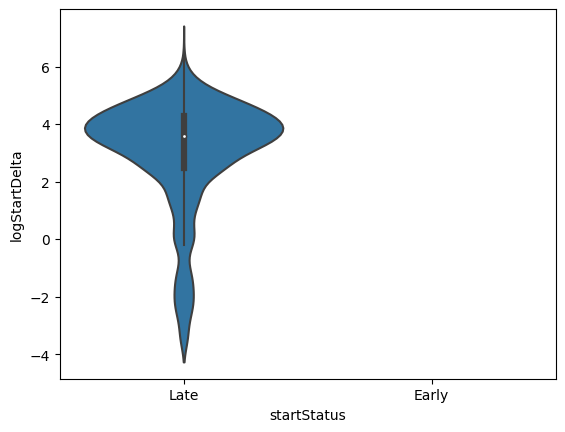

In [71]:
# # make box and whisker plots for projectStarts and projectFinishes where they weren't started or finished on time
# sns.boxplot(x="startStatus", y="starting_delta", data=projectStarts[projectStarts['startStatus'] != 'On Time'])
# sns.boxplot(x="endStatus", y="ending_delta", data=projectFinishes[projectFinishes['ending_delta'] != 0])


""" how to hangle skeweness of the data? 
    - if we convert to log scale then negative values will be undefined
        -> try doing an np.select to convert the negative values to positive, then take the log, then convert back to negative

        OR just get rid of the negative values since I really only care about the delayed projects
"""


projectStarts['logStartDelta'] = np.log(projectStarts['starting_delta'])
projectFinishes['logFinishDelta'] = np.log(projectFinishes['ending_delta'])

# logStartDeltas = np.log(projectStarts[projectStarts['starting_delta'] != 0]['starting_delta'])
# logFinishDeltas = np.log(projectFinishes[projectFinishes['ending_delta'] != 0]['ending_delta'])
# sns.displot(logStartDeltas, kde=True);
# sns.displot(logFinishDeltas, kde=True);


# sns.violinplot(x="startStatus", y="logStartDelta", data=projectStarts[projectStarts['startStatus'] != 'On Time'])
# sns.displot(projectStarts[projectStarts['startStatus'] != 'On Time']['starting_delta'], bins=20, kde=False, rug=True);

## Q1 Answer: Kind of
-> 25.2% of projects were late (2170/8970 )  
-> 94.7% of projects that were started late were finished late (1672/1765)  
-> 67.2% of projects were completed on time (6032/8970)

Plots
- side by side boxplots of time deltas by start and end on time, early, and late
- [ x ] heat map of where time deltas are
- 

#Q2 - How much do these projects cost?
- Capital Project Detail Dollars [link](https://data.cityofnewyork.us/City-Government/Capital-Project-Detail-Data-Dollars/wa2y-rh4b)

filter the dollars data by projects that are completed 
- add buckets for months? 
- 


# Q2 - Budget

In [29]:
small.columns

Index(['project_id', 'managing_agency', 'boro', 'orig_start', 'actual_start',
       'step', 'task', 'starting_delta', 'ending_delta'],
      dtype='object')

In [32]:
budget = pd.read_csv('data/budget.csv') # 72437 rows, 9 columns

# There are more projects in the small dataframe than in the budget dataframe
budget.groupby("project_id").nunique() # 8578 projects
small.groupby("project_id").nunique()  # 8966 projects

# merge budget and small on project_id (inner join)
costs = budget[['project_id','boro','managing_agcy','orig_bud_amt','city_plan_total','noncity_plan_total']]\
    .merge(small[['project_id','starting_delta','ending_delta']], on='project_id', how='inner')

In [33]:
costs['project_id'].nunique() # 8578 projects

8578

In [44]:
projectCosts = costs.groupby('project_id').agg({'boro':'first',
                                 'managing_agcy': 'first',
                                 'orig_bud_amt': 'first', 
                                 'city_plan_total': 'max', 
                                 'noncity_plan_total': 'sum',
                                 'starting_delta': 'first',
                                 'ending_delta': 'first'}).reset_index()

projectCosts['total_cost']= projectCosts['city_plan_total'] + projectCosts['noncity_plan_total']
projectCosts['cost_delta']= projectCosts['total_cost'] - projectCosts['orig_bud_amt']
projectCosts['costStatus'] = np.select([
                                    (projectCosts['cost_delta'] < 0),    # Condition for "early"
                                    (projectCosts['cost_delta'] > 0)     # Condition for "late"
                                ],
                                [
                                    'Under Budget',
                                    'Over Budget'
                                ],
                                default='On Target'  # Default value if none of the conditions are met
                            )   
projectCosts = projectCosts.merge(projectStarts[['project_id','startStatus']], 
                                    on='project_id', 
                                    how='inner')        \
                .merge(projectFinishes[['project_id','endStatus']], 
                                    on='project_id', 
                                    how='inner')

In [49]:

costStatusHeatMapDF = projectCosts.groupby(['costStatus','endStatus']).size().unstack()

costStatusHeatMapDF  = costStatusHeatMapDF.reindex(columns=["Late","On Time","Early"],index=["Under Budget","On Target","Over Budget"]).T

costStatusHeatMapDF

costStatus,Under Budget,On Target,Over Budget
endStatus,,,
Late,217,471,1247
On Time,1012,1620,3330
Early,87,115,479


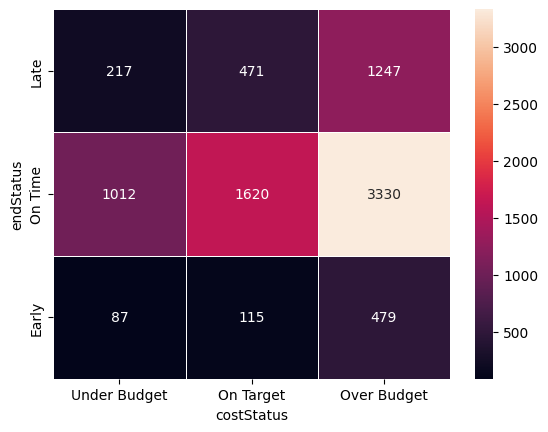

In [50]:
sns.heatmap(costStatusHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5);

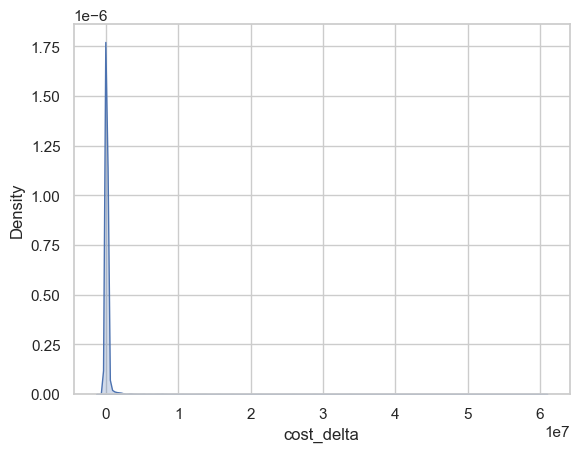

In [79]:
# sns.displot(projectCosts[projectCosts['costStatus'] == 'Over Budget']['cost_delta'], bins=5, kde=False);


# sns.kdeplot(projectCosts[projectCosts['costStatus'] == 'Over Budget']['cost_delta'], fill=True);
sns.kdeplot(projectCosts['cost_delta'], fill=True,common_norm=True);
# plt.xlim(-1e6, 1e6)

## Avg Project Task Delay by Managing Agency

In [ ]:
# # Vertical bar
# small.groupby('managing_agency').mean().plot(kind='bar');
# plt.title('Average Project Delay (Months) \nby Managing Agency');
# plt.ylabel('Months');
# plt.xlabel('Managing Agency');
# plt.xticks(rotation=45,ha='right');
# plt.legend(['Starting Delay','Ending Delay'],loc='upper left', bbox_to_anchor=(-0.5, 1));

# Horizontal bar
small.groupby('managing_agency').mean().plot(kind='barh');
plt.title('Average Task Delay (Months) \nby Managing Agency');
plt.ylabel('Managing Agency');
plt.xlabel('Months');
plt.legend(['Starting Delay','Ending Delay'],loc='upper right');
plt.savefig('plots/avg_delay_by_agency.png');

## Top 5 Projects (Late and Early)

In [ ]:
small[#( small['step'] == 1 ) &
        (small['task'] == 'CONSTRUCTION START') &
        ( small['starting_delay_m'] > 0 )
      ].sort_values(by='starting_delay_m',ascending=False).head(10)